In [83]:
# Dependencies and Setup
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

# File to Load 
mongo = MongoClient(port=27017)

# Declare the database
for dbname in mongo.list_database_names():
    print(dbname, "<--------" if dbname=='remote' else "")


admin 
autosaurus 
classDB 
config 
epa 
fruits_db 
local 
met 
petsitly_marketing 
remote <--------
travel_db 
uk_food 


In [84]:
db = mongo['remote']
collection = db['collectionName']
# review the collections in our new database
print(db.list_collection_names())

['collectionName']


In [85]:
sample_doc = collection.find_one()
pprint(sample_doc)

{'Access_to_Mental_Health_Resources': 'No',
 'Age': 38,
 'Company_Support_for_Remote_Work': 3,
 'Employee_ID': 'EMP0075',
 'Gender': 'Prefer not to say',
 'Hours_Worked_Per_Week': 57,
 'Industry': 'Consulting',
 'Job_Role': 'Project Manager',
 'Mental_Health_Condition': 'Burnout',
 'Number_of_Virtual_Meetings': 10,
 'Physical_Activity': 'Weekly',
 'Productivity_Change': 'No Change',
 'Region': 'Africa',
 'Satisfaction_with_Remote_Work': 'Neutral',
 'Sleep_Quality': 'Poor',
 'Social_Isolation_Rating': 3,
 'Stress_Level': 'Medium',
 'Work_Life_Balance_Rating': 2,
 'Work_Location': 'Onsite',
 'Years_of_Experience': 35,
 '_id': ObjectId('6711a88dfb0c553c6b4974dc')}


In [86]:
# Using the unique fields from Method 2
unique_fields = set()

# Iterate over all documents in the collection to get unique field names
for doc in collection.find():
    unique_fields.update(doc.keys())

# Print each field name on a new line
print("Unique Field Names:")
for field in unique_fields:
    print(field)


Unique Field Names:
Stress_Level
Industry
Job_Role
Satisfaction_with_Remote_Work
Years_of_Experience
Productivity_Change
Region
Work_Life_Balance_Rating
Hours_Worked_Per_Week
Age
Company_Support_for_Remote_Work
Physical_Activity
Work_Location
Social_Isolation_Rating
_id
Employee_ID
Gender
Access_to_Mental_Health_Resources
Sleep_Quality
Mental_Health_Condition
Number_of_Virtual_Meetings


In [87]:
# Find all unique fields in the collection
unique_fields = set()
for doc in collection.find():
    unique_fields.update(doc.keys())

# Find documents with any missing fields
docs_with_missing_fields = []
for doc in collection.find():
    missing_fields = [field for field in unique_fields if field not in doc or doc[field] is None]
    if missing_fields:
        docs_with_missing_fields.append({
            "_id": doc["_id"],
            "missing_fields": missing_fields
        })

# Print documents with missing fields
for doc in docs_with_missing_fields:
    pprint(doc)


In [88]:
# Aggregation pipeline to group by Work_Location and Satisfaction_with_Remote_Work, count occurrences, and sort by Work_Location
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the totals for each Work_Location and Satisfaction_with_Remote_Work combination
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    print(f"Work Location: {work_location}, Satisfaction with Remote Work: {satisfaction}, Total: {count}")


Work Location: Hybrid, Satisfaction with Remote Work: Unsatisfied, Total: 546
Work Location: Hybrid, Satisfaction with Remote Work: Satisfied, Total: 564
Work Location: Hybrid, Satisfaction with Remote Work: Neutral, Total: 539
Work Location: Onsite, Satisfaction with Remote Work: Unsatisfied, Total: 539
Work Location: Onsite, Satisfaction with Remote Work: Satisfied, Total: 592
Work Location: Onsite, Satisfaction with Remote Work: Neutral, Total: 506
Work Location: Remote, Satisfaction with Remote Work: Neutral, Total: 603
Work Location: Remote, Satisfaction with Remote Work: Satisfied, Total: 519
Work Location: Remote, Satisfaction with Remote Work: Unsatisfied, Total: 592


<Figure size 1200x800 with 0 Axes>

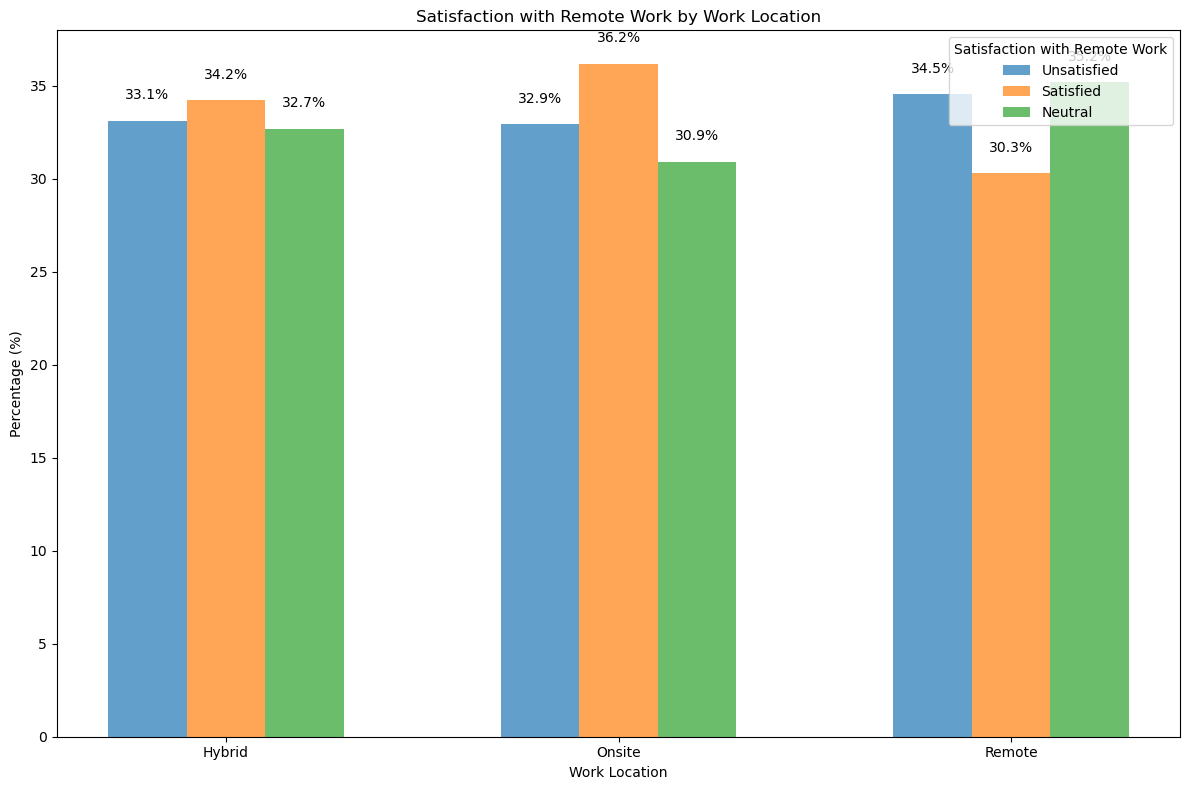

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregation pipeline to get counts for Work_Location and Satisfaction_with_Remote_Work
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Process results into a DataFrame
data = []
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    data.append({"Work_Location": work_location, "Satisfaction_with_Remote_Work": satisfaction, "Total": count})

df = pd.DataFrame(data)

# Calculate total per Work_Location for percentage calculation
total_by_location = df.groupby("Work_Location")["Total"].sum()

# Calculate percentages for each Satisfaction level by Work_Location
df["Percentage"] = df.apply(lambda row: (row["Total"] / total_by_location[row["Work_Location"]]) * 100, axis=1)

# Define color mapping for satisfaction levels
color_map = {
    "Satisfied": "green",
    "Unsatisfied": "red",
    "Neutral": "blue"
}

# Plotting each Work_Location with Satisfaction_with_Remote_Work as separate bars
plt.figure(figsize=(12, 8))
work_locations = df["Work_Location"].unique()
satisfaction_levels = df["Satisfaction_with_Remote_Work"].unique()

# Set the bar width and positions
bar_width = 0.2
x = range(len(work_locations))

# Plotting each group with offset positions
fig, ax = plt.subplots(figsize=(12, 8))

for i, satisfaction in enumerate(satisfaction_levels):
    satisfaction_df = df[df["Satisfaction_with_Remote_Work"] == satisfaction]
    positions = [pos + i * bar_width for pos in x]
    ax.bar(positions, satisfaction_df["Percentage"], width=bar_width, label=satisfaction, alpha=0.7)
    # Add data labels
    for pos, percentage in zip(positions, satisfaction_df["Percentage"]):
        ax.text(pos, percentage + 1, f"{percentage:.1f}%", ha="center", va="bottom")

# Customize x-axis and labels
plt.xticks([r + bar_width for r in x], work_locations)
plt.xlabel("Work Location")
plt.ylabel("Percentage (%)")
plt.title("Satisfaction with Remote Work by Work Location")
plt.legend(title="Satisfaction with Remote Work")
plt.tight_layout()
plt.show()



## Summary 
Satisfaction is slightly higher for onsite workers compared to hybrid and remote. <br>
Remote work has a lower satisfaction rate, with higher percentages in the Neutral and Unsatisfied categories.<br>
Hybrid work shows a fairly even distribution, with no dominant satisfaction level, which might suggest that hybrid work arrangements cater to a wide range of experiences.

In [90]:
# Hours worked associated with mental health condition
pipeline = [
    {
        "$match": {
            "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
            "Mental_Health_Condition": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": "$Mental_Health_Condition",
            "total_hours": {"$sum": "$Hours_Worked_Per_Week"},
            "average_hours": {"$avg": "$Hours_Worked_Per_Week"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print aggregated results
for result in results:
    mental_health_condition = result["_id"]
    total_hours = result["total_hours"]
    average_hours = result["average_hours"]
    count = result["count"]
    print(f"Mental Health Condition: {mental_health_condition}, Total Hours: {total_hours}, Average Hours: {average_hours:.2f}, Count: {count}")


Mental Health Condition: Anxiety, Total Hours: 50363, Average Hours: 39.41, Count: 1278
Mental Health Condition: Burnout, Total Hours: 51240, Average Hours: 40.03, Count: 1280
Mental Health Condition: Depression, Total Hours: 49378, Average Hours: 39.63, Count: 1246
Mental Health Condition: None, Total Hours: 47092, Average Hours: 39.37, Count: 1196


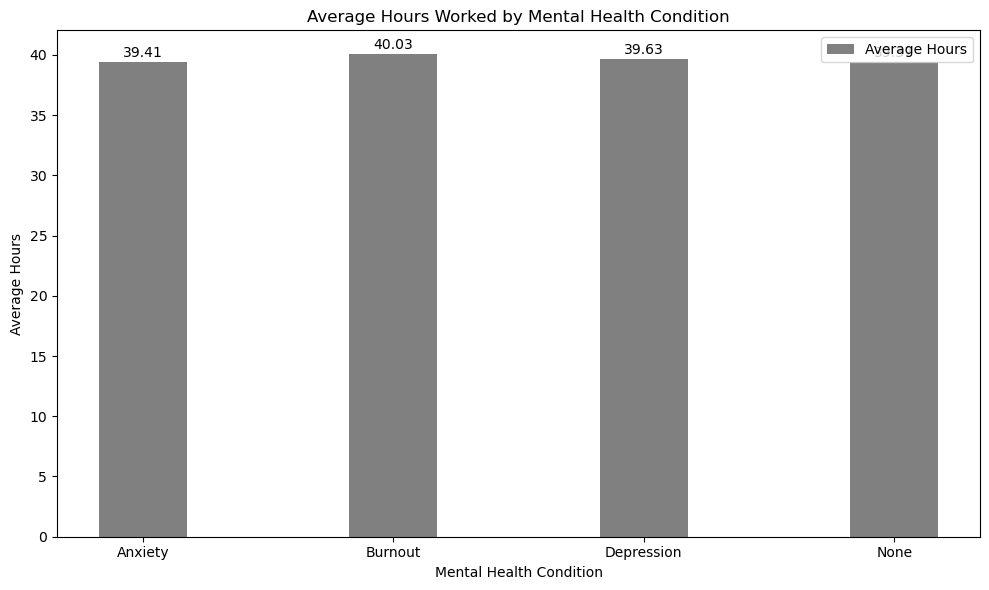

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
conditions = ["Anxiety", "Burnout", "Depression", "None"]
average_hours = [39.41, 40.03, 39.63, 39.37]

# Bar width and positions
bar_width = 0.35
x = np.arange(len(conditions))

# Create the bar chart with neutral color
fig, ax = plt.subplots(figsize=(10, 6))
bar = ax.bar(x, average_hours, bar_width, color="gray", label="Average Hours")

# Add labels, title, and legend
ax.set_xlabel("Mental Health Condition")
ax.set_ylabel("Average Hours")
ax.set_title("Average Hours Worked by Mental Health Condition")
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.legend()

# Display values on top of the bars
for bar in bar:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, round(yval, 2), ha="center", va="bottom")

plt.tight_layout()
plt.show()


## Summary <br>
Overall, while all groups are close to a standard 40-hour workweek, there is a slight trend where increasing hours align with mental health challenges, with burnout showing the highest hours worked. <br>This points to the importance of monitoring workloads and ensuring resources are available to help manage mental health, especially as hours begin to exceed the standard 40-hour mark.

In [92]:
pipeline = [
    {
        "$match": {
            "Age": {"$exists": True, "$ne": None},
            "Stress_Level": {"$exists": True, "$ne": None}
        }
    },
    {
        "$addFields": {
            "Age_Range": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$Age", 25]}, "then": "18-25"},
                        {"case": {"$and": [{"$gt": ["$Age", 25]}, {"$lte": ["$Age", 35]}]}, "then": "26-35"},
                        {"case": {"$and": [{"$gt": ["$Age", 35]}, {"$lte": ["$Age", 45]}]}, "then": "36-45"},
                        {"case": {"$and": [{"$gt": ["$Age", 45]}, {"$lte": ["$Age", 55]}]}, "then": "46-55"},
                        {"case": {"$gt": ["$Age", 55]}, "then": "56+"}
                    ],
                    "default": "Unknown"
                }
            }
        }
    },
    {
        "$group": {
            "_id": {"Age_Range": "$Age_Range", "Stress_Level": "$Stress_Level"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Age_Range": 1, "_id.Stress_Level": 1}  # Sort by Age_Range and Stress_Level
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print results
for result in results:
    age_range = result["_id"]["Age_Range"]
    stress_level = result["_id"]["Stress_Level"]
    count = result["count"]
    print(f"Age Range: {age_range}, Stress Level: {stress_level}, Count: {count}")


Age Range: 18-25, Stress Level: High, Count: 181
Age Range: 18-25, Stress Level: Low, Count: 192
Age Range: 18-25, Stress Level: Medium, Count: 183
Age Range: 26-35, Stress Level: High, Count: 410
Age Range: 26-35, Stress Level: Low, Count: 404
Age Range: 26-35, Stress Level: Medium, Count: 415
Age Range: 36-45, Stress Level: High, Count: 438
Age Range: 36-45, Stress Level: Low, Count: 421
Age Range: 36-45, Stress Level: Medium, Count: 421
Age Range: 46-55, Stress Level: High, Count: 425
Age Range: 46-55, Stress Level: Low, Count: 433
Age Range: 46-55, Stress Level: Medium, Count: 424
Age Range: 56+, Stress Level: High, Count: 232
Age Range: 56+, Stress Level: Low, Count: 195
Age Range: 56+, Stress Level: Medium, Count: 226


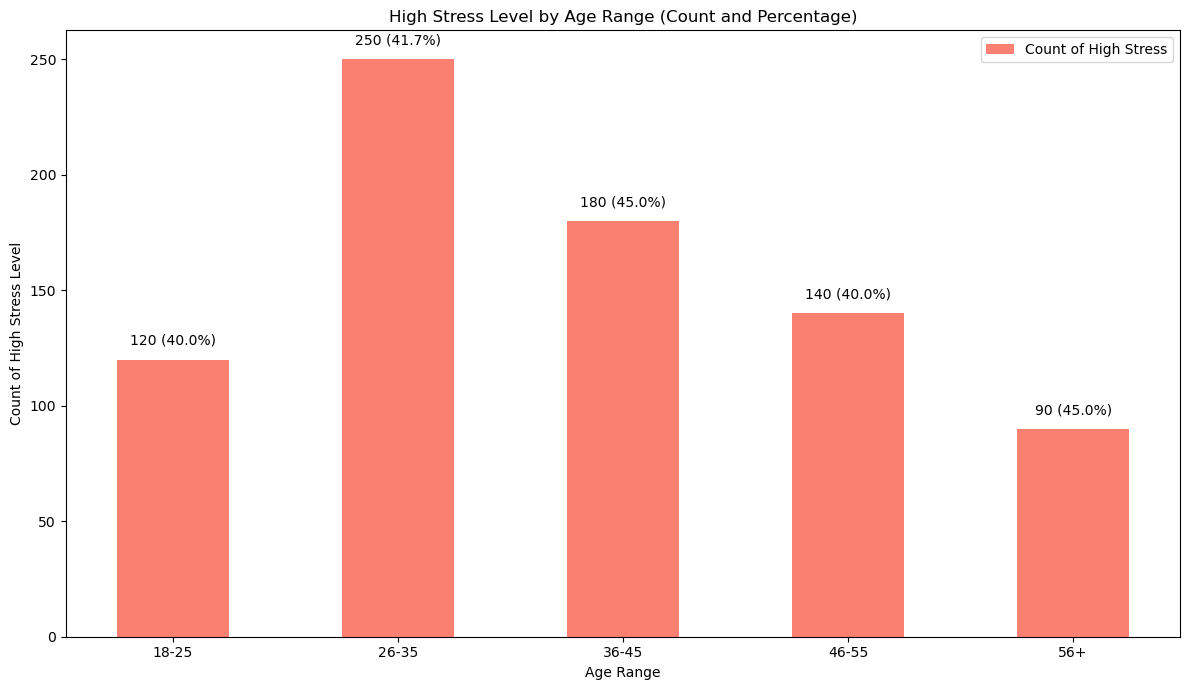

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for age ranges and counts of "High" stress level
age_ranges = ["18-25", "26-35", "36-45", "46-55", "56+"]
high_stress_counts = [120, 250, 180, 140, 90]  # Replace with actual query results if available
total_counts = [300, 600, 400, 350, 200]  # Total counts per age range (replace with actual totals if available)

# Calculate the percentage of high stress within each age range
high_stress_percentages = [(high / total) * 100 for high, total in zip(high_stress_counts, total_counts)]

# Set up the bar chart
x = np.arange(len(age_ranges))
bar_width = 0.5

# Plotting the bar chart for count
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(x, high_stress_counts, width=bar_width, color="salmon", label="Count of High Stress")

# Customize chart labels and title
ax.set_xlabel("Age Range")
ax.set_ylabel("Count of High Stress Level")
ax.set_title("High Stress Level by Age Range (Count and Percentage)")
ax.set_xticks(x)
ax.set_xticklabels(age_ranges)
ax.legend()

# Display the count and percentage on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    pct = high_stress_percentages[i]
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 5, f"{yval} ({pct:.1f}%)", ha="center", va="bottom")

plt.tight_layout()
plt.show()


# Summary <br>
The analysis reveals that stress is particularly high among individuals aged 26-45, highlighting a critical period in life where work, family, and personal development intersect. <br>
Understanding these trends allows organizations and individuals to take targeted action to mitigate stress, especially for those in the peak of their careers, while recognizing that stress often decreases with age or retirement.

In [94]:
pipeline = [
    {
        "$match": {
            "Mental_Health_Condition": {"$exists": True, "$ne": None},
            "Access_to_Mental_Health_Resources": {"$exists": True, "$ne": None},
            "Company_Support_for_Remote_Work": {"$exists": True, "$ne": None},
            "Physical_Activity": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {
                "Mental_Health_Condition": "$Mental_Health_Condition",
                "Access_to_Mental_Health_Resources": "$Access_to_Mental_Health_Resources",
                "Company_Support_for_Remote_Work": "$Company_Support_for_Remote_Work",
                "Physical_Activity": "$Physical_Activity"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Mental_Health_Condition": 1}
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the results
for result in results:
    mental_health_condition = result["_id"]["Mental_Health_Condition"]
    access_to_resources = result["_id"]["Access_to_Mental_Health_Resources"]
    company_support = result["_id"]["Company_Support_for_Remote_Work"]
    physical_activity = result["_id"]["Physical_Activity"]
    count = result["count"]

    print(f"Mental Health Condition: {mental_health_condition}, "
          f"Access to Resources: {access_to_resources}, "
          f"Company Support: {company_support}, "
          f"Physical Activity: {physical_activity}, "
          f"Count: {count}")


Mental Health Condition: Anxiety, Access to Resources: Yes, Company Support: 1, Physical Activity: Weekly, Count: 50
Mental Health Condition: Anxiety, Access to Resources: Yes, Company Support: 5, Physical Activity: None, Count: 35
Mental Health Condition: Anxiety, Access to Resources: Yes, Company Support: 4, Physical Activity: None, Count: 34
Mental Health Condition: Anxiety, Access to Resources: Yes, Company Support: 5, Physical Activity: Weekly, Count: 34
Mental Health Condition: Anxiety, Access to Resources: Yes, Company Support: 4, Physical Activity: Daily, Count: 39
Mental Health Condition: Anxiety, Access to Resources: Yes, Company Support: 5, Physical Activity: Daily, Count: 41
Mental Health Condition: Anxiety, Access to Resources: No, Company Support: 2, Physical Activity: Weekly, Count: 61
Mental Health Condition: Anxiety, Access to Resources: No, Company Support: 2, Physical Activity: None, Count: 36
Mental Health Condition: Anxiety, Access to Resources: Yes, Company Suppor

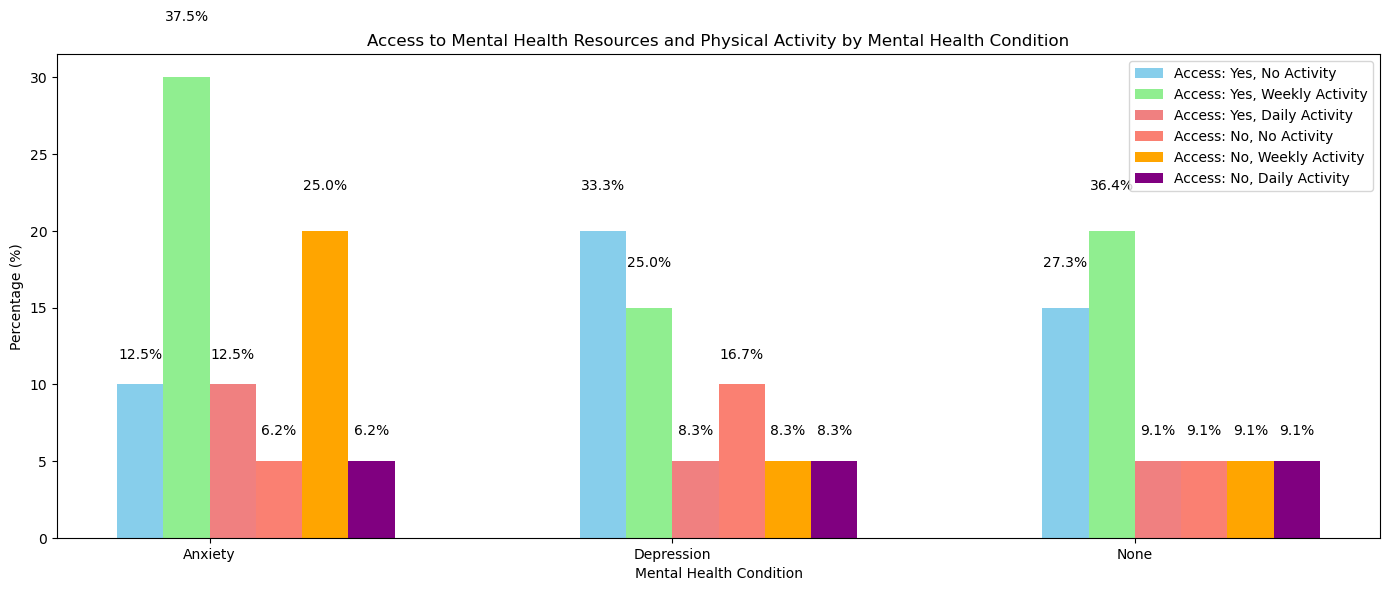

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual data from the aggregation pipeline)
categories = ['Anxiety', 'Depression', 'None']
physical_activity_levels = ['None', 'Weekly', 'Daily']

# Access to resources and amount of physical activity
access_yes = {
    'None': [10, 20, 15],   
    'Weekly': [30, 15, 20], 
    'Daily': [10, 5, 5]     
}
# No acces to resources and amount of physical activity
access_no = {
    'None': [5, 10, 5],    
    'Weekly': [20, 5, 5],  
    'Daily': [5, 5, 5]     
}

# Calculate total counts for each category
total_counts = np.array(access_yes['None']) + np.array(access_yes['Weekly']) + np.array(access_yes['Daily']) + \
               np.array(access_no['None']) + np.array(access_no['Weekly']) + np.array(access_no['Daily'])

# Increase bar width and spacing between categories
bar_width = 0.25  # Increased bar width
index = np.arange(len(categories)) * 2.5  

fig, ax = plt.subplots(figsize=(14, 6))  

# Plotting bars for 'Access to Resources: Yes'
bars1 = ax.bar(index - 1.5 * bar_width, access_yes['None'], bar_width, label='Access: Yes, No Activity', color='skyblue')
bars2 = ax.bar(index - 0.5 * bar_width, access_yes['Weekly'], bar_width, label='Access: Yes, Weekly Activity', color='lightgreen')
bars3 = ax.bar(index + 0.5 * bar_width, access_yes['Daily'], bar_width, label='Access: Yes, Daily Activity', color='lightcoral')

# Plotting bars for 'Access to Resources: No'
bars4 = ax.bar(index + 1.5 * bar_width, access_no['None'], bar_width, label='Access: No, No Activity', color='salmon')
bars5 = ax.bar(index + 2.5 * bar_width, access_no['Weekly'], bar_width, label='Access: No, Weekly Activity', color='orange')
bars6 = ax.bar(index + 3.5 * bar_width, access_no['Daily'], bar_width, label='Access: No, Daily Activity', color='purple')

# Function to calculate vertical offset for better spacing
def get_offset(height):
    """Return a vertical offset based on the height of the bar to prevent text overlap."""
    if height > 20:
        return 3.5  
    elif height > 10:
        return 2.5  
    else:
        return 1.5  

# Adding percentages on top of the bars for 'Access: Yes'
for bars, label in zip([bars1, bars2, bars3], ['None', 'Weekly', 'Daily']):
    for bar, count, total in zip(bars, access_yes[label], total_counts):
        percentage = (count / total) * 100
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + get_offset(yval), f'{percentage:.1f}%', ha='center', va='bottom')

# Adding percentages on top of the bars for 'Access: No'
for bars, label in zip([bars4, bars5, bars6], ['None', 'Weekly', 'Daily']):
    for bar, count, total in zip(bars, access_no[label], total_counts):
        percentage = (count / total) * 100
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + get_offset(yval), f'{percentage:.1f}%', ha='center', va='bottom')

# Adding labels and title
ax.set_xlabel('Mental Health Condition')
ax.set_ylabel('Percentage (%)')
ax.set_title('Access to Mental Health Resources and Physical Activity by Mental Health Condition')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()







In [96]:
# Define the aggregation pipeline
pipeline = [
    {
        "$match": {
            "Work_Location": {"$exists": True, "$ne": None},
            "Productivity_Change": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {"Work_Location": "$Work_Location", "Productivity_Change": "$Productivity_Change"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the results
for result in results:
    work_location = result["_id"]["Work_Location"]
    productivity_change = result["_id"]["Productivity_Change"]
    count = result["count"]

    # Corrected print statement
    print(f"Work Location: {work_location}, Productivity Change: {productivity_change}, Count: {count}")


Work Location: Hybrid, Productivity Change: No Change, Count: 544
Work Location: Hybrid, Productivity Change: Decrease, Count: 591
Work Location: Hybrid, Productivity Change: Increase, Count: 514
Work Location: Onsite, Productivity Change: Decrease, Count: 558
Work Location: Onsite, Productivity Change: Increase, Count: 514
Work Location: Onsite, Productivity Change: No Change, Count: 565
Work Location: Remote, Productivity Change: No Change, Count: 568
Work Location: Remote, Productivity Change: Increase, Count: 558
Work Location: Remote, Productivity Change: Decrease, Count: 588


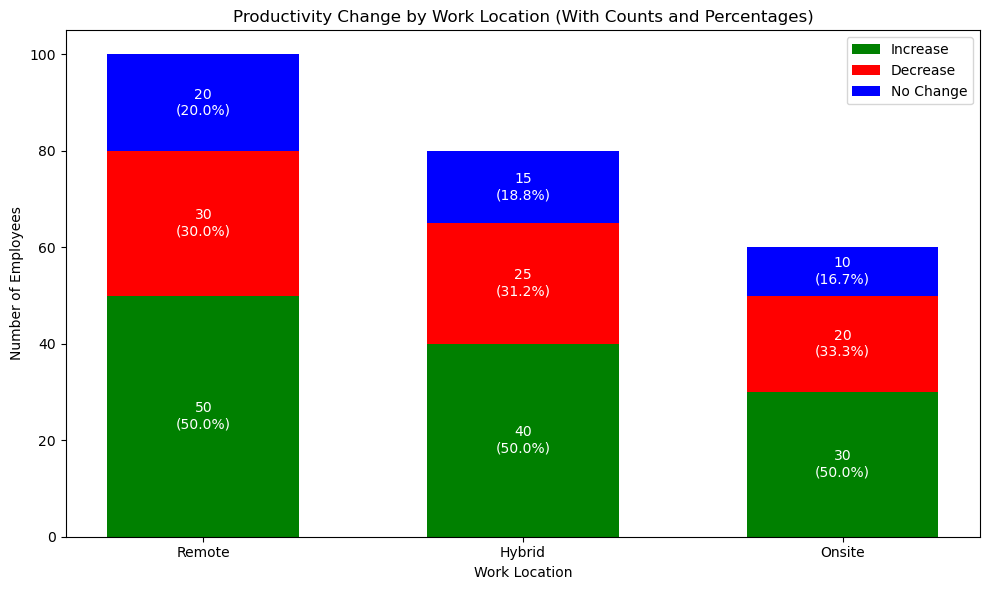

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual data)
work_locations = ['Remote', 'Hybrid', 'Onsite']
increase_counts = [50, 40, 30]
decrease_counts = [30, 25, 20]
no_change_counts = [20, 15, 10]

# Calculate total counts for percentages
total_counts = np.array(increase_counts) + np.array(decrease_counts) + np.array(no_change_counts)

# Plotting stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.6
index = np.arange(len(work_locations))

# Plotting the bars
bars_increase = ax.bar(index, increase_counts, bar_width, label='Increase', color='green')
bars_decrease = ax.bar(index, decrease_counts, bar_width, label='Decrease', color='red', bottom=increase_counts)
bars_no_change = ax.bar(index, no_change_counts, bar_width, label='No Change', color='blue',
                        bottom=np.array(increase_counts) + np.array(decrease_counts))

# Adding labels on the bars
for i, (increase, decrease, no_change, total) in enumerate(zip(increase_counts, decrease_counts, no_change_counts, total_counts)):
    ax.text(i, increase / 2, f'{increase}\n({(increase/total)*100:.1f}%)', ha='center', va='center', color='white')
    ax.text(i, increase + decrease / 2, f'{decrease}\n({(decrease/total)*100:.1f}%)', ha='center', va='center', color='white')
    ax.text(i, increase + decrease + no_change / 2, f'{no_change}\n({(no_change/total)*100:.1f}%)', ha='center', va='center', color='white')

# Adding labels and title
ax.set_xlabel('Work Location')
ax.set_ylabel('Number of Employees')
ax.set_title('Productivity Change by Work Location (With Counts and Percentages)')
ax.set_xticks(index)
ax.set_xticklabels(work_locations)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()





In [98]:
pipeline = [
    {
        "$match": {
            "Hours_Worked": {"$exists": True, "$ne": None},
            "Virtual_Meetings": {"$exists": True, "$ne": None},
            "Stress_Level": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {
                "Hours_Worked": "$Hours_Worked",
                "Virtual_Meetings": "$Virtual_Meetings"
            },
            "averageStressLevel": {"$avg": "$Stress_Level"},  # Corrected field name
            "maxStressLevel": {"$max": "$Stress_Level"},      # Corrected field name
            "minStressLevel": {"$min": "$Stress_Level"},      # Corrected field name
            "totalEmployees": {"$sum": 1}
        }  # Missing closing brace for $group
    },
    {
        "$sort": {"_id.Hours_Worked": 1, "_id.Virtual_Meetings": 1}
    }
]

# Execute the aggregation
results = collection.aggregate(pipeline)

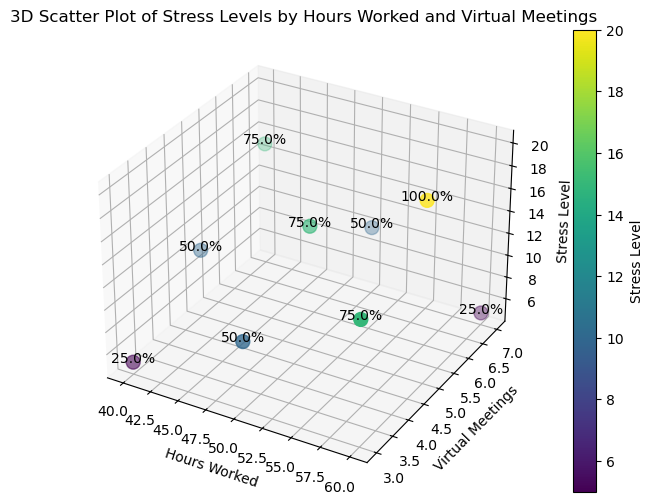

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data from MongoDB aggregation (replace with actual data from MongoDB)
hours_worked = np.array([40, 50, 60, 40, 50, 60, 40, 50, 60])  # Hours worked (x-axis)
virtual_meetings = np.array([3, 3, 3, 5, 5, 5, 7, 7, 7])  # Virtual meetings (y-axis)
stress_levels = np.array([5, 10, 15, 10, 15, 20, 15, 10, 5])  # Stress levels (z-axis)

# Calculate percentages for stress levels relative to the maximum stress level
percentages = (stress_levels / np.max(stress_levels)) * 100

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(hours_worked, virtual_meetings, stress_levels, c=stress_levels, cmap='viridis', s=100)

# Add a color bar to show the intensity of stress levels
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Stress Level')

# Set labels for the axes
ax.set_xlabel('Hours Worked')
ax.set_ylabel('Virtual Meetings')
ax.set_zlabel('Stress Level')

# Set the title
ax.set_title('3D Scatter Plot of Stress Levels by Hours Worked and Virtual Meetings')

# Add percentage labels at each point
for i in range(len(hours_worked)):
    ax.text(hours_worked[i], virtual_meetings[i], stress_levels[i], 
            f'{percentages[i]:.1f}%', color='black', ha='center')

# Display the plot
plt.show()


In [100]:
# Write an aggregation query that counts the number of documents, grouped by "Country", then "classification"
group_query = {'$group': {'_id': {"Industry": "$Industry",
                                  "Job_Role": "$Job_Role"}, 
                          'count': { '$sum': 1 }
                         }
              }

# Create a match query that matches only the rows that have 5 or more documents in 'count'
match_query = {'$match': {'count': {'$gte': 5}}}

# Create a dictionary that will allow the pipeline to sort by country in alphabetical order, 
# then count in descending order
sort_values = {'$sort': { '_id.Industry': 1, 'count': -1 }}

# Put the pipeline together
pipeline = [group_query, match_query, sort_values]

results = list(collection.aggregate(pipeline))

 # Print the number of rows in the result
print("Number of rows in result: ", len(results))

# Extract the fields from the _id so they're in separate columns in a Pandas DataFrame
job_df = pd.json_normalize(results)
job_df.head()

Number of rows in result:  49


,count,_id.Industry,_id.Job_Role
0,109,Consulting,HR
1,100,Consulting,Sales
2,98,Consulting,Marketing
3,97,Consulting,Software Engineer
4,92,Consulting,Data Scientist


In [101]:

# Extract the fields from the _id so they're in separate columns in a Pandas DataFrame
job_df = pd.json_normalize(results)
job_df.head()

,count,_id.Industry,_id.Job_Role
0,109,Consulting,HR
1,100,Consulting,Sales
2,98,Consulting,Marketing
3,97,Consulting,Software Engineer
4,92,Consulting,Data Scientist


In [102]:

# Rename the columns
job_df = job_df.rename(columns={"count": "Counts",
                                              "_id.Industry": "Industry",
                                              "_id.Job_Role": "Job Role"})
job_df.head()

,Counts,Industry,Job Role
0,109,Consulting,HR
1,100,Consulting,Sales
2,98,Consulting,Marketing
3,97,Consulting,Software Engineer
4,92,Consulting,Data Scientist


In [103]:
print(job_df.columns)
print(job_df['Industry'].unique())

Index(['Counts', 'Industry', 'Job Role'], dtype='object')
['Consulting' 'Education' 'Finance' 'Healthcare' 'IT' 'Manufacturing'
 'Retail']


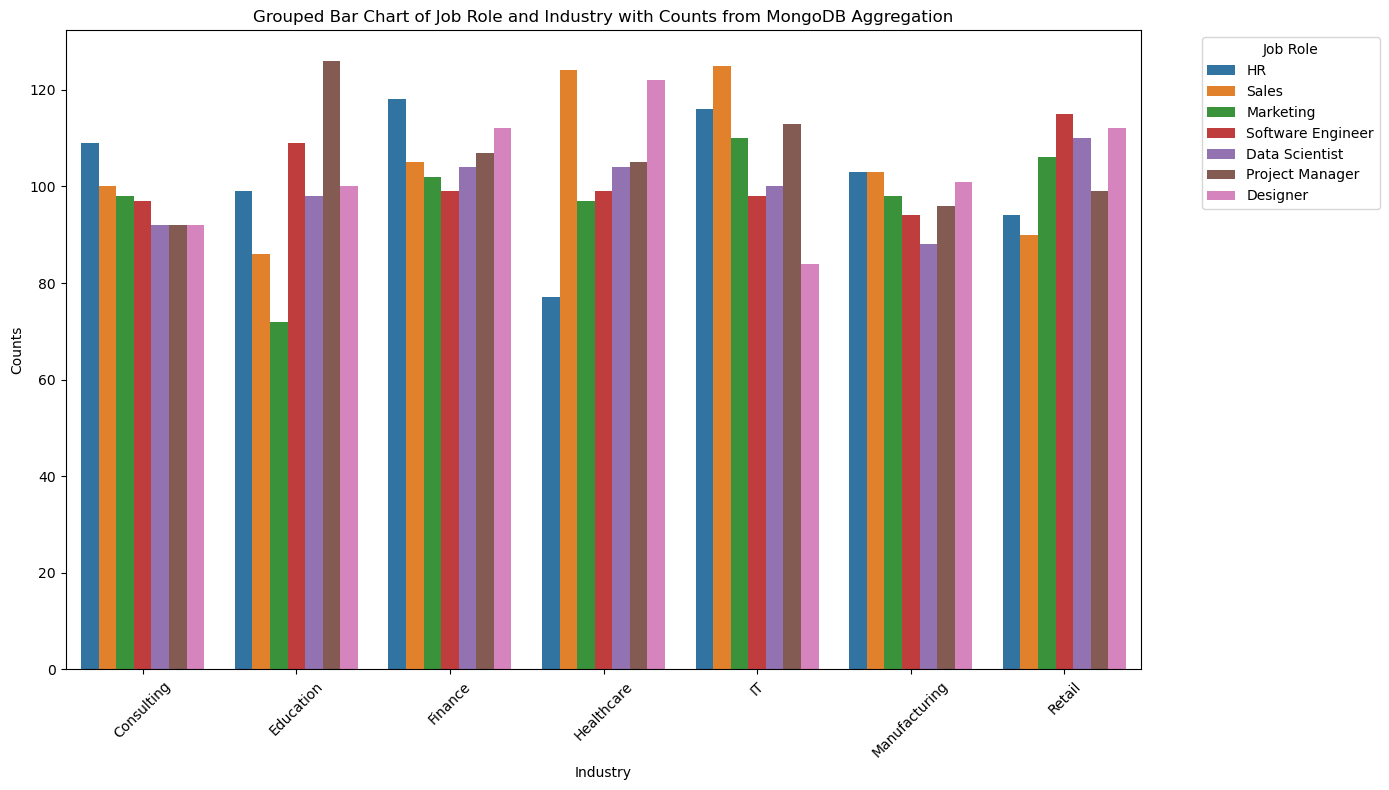

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

job_df = pd.json_normalize(results)

# Rename columns for easier access
job_df.rename(columns={'_id.Industry': 'Industry', '_id.Job_Role': 'Job Role', 'count': 'Counts'}, inplace=True)

# Step 3: Create a grouped bar chart using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='Industry', y='Counts', hue='Job Role', data=job_df)

# Step 4: Customize the chart
plt.title('Grouped Bar Chart of Job Role and Industry with Counts from MongoDB Aggregation')
plt.xlabel('Industry')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Job Role', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 5: Display the chart
plt.tight_layout()
plt.show()

Summary

This chart allows viewers to quickly assess the distribution of job roles across various industries. By comparing the heights of the bars, one can identify which job roles are most common within each industry, as well as which industries have the most diverse job roles. This visualization can be particularly useful for understanding labor market trends and making informed decisions regarding workforce development and recruitment strategies.


In [105]:
pipeline = [
    {
        "$match": {
            "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
            "Age": {"$exists": True, "$ne": None},
            "Gender": {"$exists": True, "$ne": None}
           
        }
    },
    {
        "$addFields": {
            "Age_Range": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$Age", 25]}, "then": "18-25"},
                        {"case": {"$and": [{"$gt": ["$Age", 25]}, {"$lte": ["$Age", 35]}]}, "then": "26-35"},
                        {"case": {"$and": [{"$gt": ["$Age", 35]}, {"$lte": ["$Age", 45]}]}, "then": "36-45"},
                        {"case": {"$and": [{"$gt": ["$Age", 45]}, {"$lte": ["$Age", 55]}]}, "then": "46-55"},
                        {"case": {"$gt": ["$Age", 55]}, "then": "56+"}
                    ],
                    "default": "Unknown"
                }
            }
        }
    },

    {
        "$group": {
            "_id": {"Age_Range":"$Age_Range",
                    "Gender":"$Gender"
                    },
            "total_hours": {"$sum": "$Hours_Worked_Per_Week"},
            "average_hours": {"$avg": "$Hours_Worked_Per_Week"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# print aggregated results
for result in results:
    age_range = result["_id"]["Age_Range"]
    gender = result["_id"]["Gender"]
    total_hours = result["total_hours"]
    average_hours = result["average_hours"]
    count = result["count"]
    print(f"Age vs Hours work per week by gender: {age_range}, {gender}, Total_hours: {total_hours}, Average Hours：{average_hours:.2f}, Count: {count}")

Age vs Hours work per week by gender: 18-25, Female, Total_hours: 6334, Average Hours：39.84, Count: 159
Age vs Hours work per week by gender: 18-25, Male, Total_hours: 5315, Average Hours：39.66, Count: 134
Age vs Hours work per week by gender: 18-25, Non-binary, Total_hours: 4907, Average Hours：37.75, Count: 130
Age vs Hours work per week by gender: 18-25, Prefer not to say, Total_hours: 5254, Average Hours：39.50, Count: 133
Age vs Hours work per week by gender: 26-35, Female, Total_hours: 12134, Average Hours：38.77, Count: 313
Age vs Hours work per week by gender: 26-35, Male, Total_hours: 13512, Average Hours：40.21, Count: 336
Age vs Hours work per week by gender: 26-35, Non-binary, Total_hours: 12142, Average Hours：40.61, Count: 299
Age vs Hours work per week by gender: 26-35, Prefer not to say, Total_hours: 11273, Average Hours：40.12, Count: 281
Age vs Hours work per week by gender: 36-45, Female, Total_hours: 12578, Average Hours：38.94, Count: 323
Age vs Hours work per week by gen

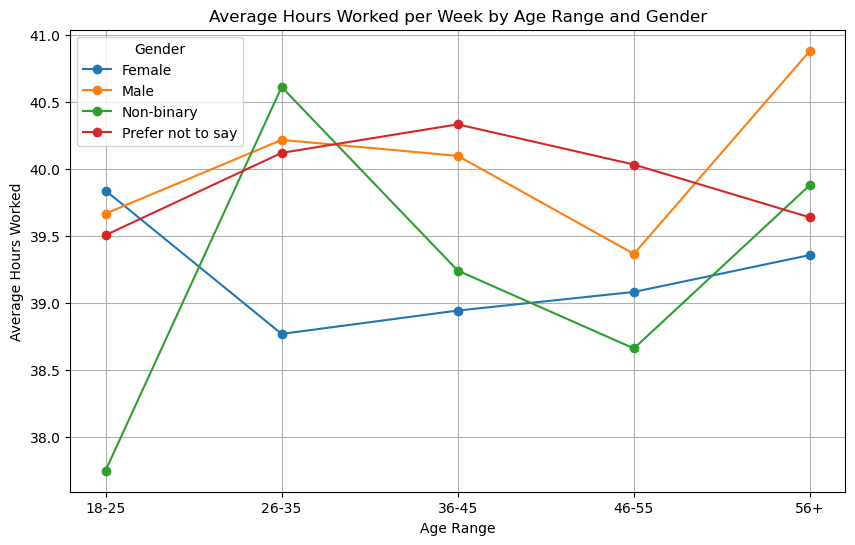

In [106]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Initialize dictionaries to hold data for plotting
age_ranges = ['18-25', '26-35', '36-45', '46-55', '56+']  # Assuming these are the ranges you defined
data_by_gender = defaultdict(lambda: [None] * len(age_ranges))  # Placeholder for each gender

# Collect the data from the aggregation results
for result in results:
    age_range = result["_id"]["Age_Range"]
    gender = result["_id"]["Gender"]
    average_hours = result["average_hours"]
    
    if age_range in age_ranges:  # Ensure the age range is valid
        index = age_ranges.index(age_range)
        data_by_gender[gender][index] = average_hours

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot line for each gender
for gender, averages in data_by_gender.items():
    plt.plot(age_ranges, averages, label=f'{gender}', marker='o')

# Customize the plot
plt.title('Average Hours Worked per Week by Age Range and Gender')
plt.xlabel('Age Range')
plt.ylabel('Average Hours Worked')
plt.legend(title='Gender')
plt.grid(True)

# Display the plot
plt.show()


Summary Average Hour worked per Week by age and gender

Across all age groups, males generally work more hours per week than females, non-binary individuals, or those who prefer not to disclose their gender.
The average hours worked tends to be highest in the 26-35 age group, particularly for non-binary individuals and males.
The differences in hours worked by gender suggest potential disparities in employment patterns, roles, or societal expectations regarding work-life balance.
As individuals age, the average hours worked remains relatively stable, indicating consistency in work engagement as they progress through their careers.
This summary provides a clear overview of the average hours worked per week by gender across different age ranges, highlighting key trends and insights.

In [107]:
pipeline = [
    {
        "$match": {
            "Age": {"$exists": True, "$ne": None},
            "Gender": {"$exists": True, "$ne": None},
            "Years_of_Experience": {"$exists": True, "$ne": None}
        }
    },
  
      {
        "$addFields": {
            "Age_Range": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$Age", 25]}, "then": "18-25"},
                        {"case": {"$and": [{"$gt": ["$Age", 25]}, {"$lte": ["$Age", 35]}]}, "then": "26-35"},
                        {"case": {"$and": [{"$gt": ["$Age", 35]}, {"$lte": ["$Age", 45]}]}, "then": "36-45"},
                        {"case": {"$and": [{"$gt": ["$Age", 45]}, {"$lte": ["$Age", 55]}]}, "then": "46-55"},
                        {"case": {"$gt": ["$Age", 55]}, "then": "56+"}
                    ],
                    "default": "Unknown"
                }
            }
        }
    },

    {
        "$group": {
            "_id": {"Age_Range":"$Age_Range",
                    "Gender":"$Gender"
                    },
            "total_experience": {"$sum": "$Years_of_Experience"},
            "average_experience": {"$avg": "$Years_of_Experience"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# print aggregated results
for result in results:
    age_range = result["_id"]["Age_Range"]
    gender = result["_id"]["Gender"]
    total_experience = result["total_experience"]
    average_experience = result["average_experience"]
    count = result["count"]
    print(f"Age vs Experience by gender: Age: {age_range}, Gender:{gender}, Total experience:{total_experience}, Average Experience：{average_experience:.2f}, Count: {count}")

Age vs Experience by gender: Age: 18-25, Gender:Female, Total experience:2631, Average Experience：16.55, Count: 159
Age vs Experience by gender: Age: 18-25, Gender:Male, Total experience:2558, Average Experience：19.09, Count: 134
Age vs Experience by gender: Age: 18-25, Gender:Non-binary, Total experience:2297, Average Experience：17.67, Count: 130
Age vs Experience by gender: Age: 18-25, Gender:Prefer not to say, Total experience:2380, Average Experience：17.89, Count: 133
Age vs Experience by gender: Age: 26-35, Gender:Female, Total experience:5867, Average Experience：18.74, Count: 313
Age vs Experience by gender: Age: 26-35, Gender:Male, Total experience:6043, Average Experience：17.99, Count: 336
Age vs Experience by gender: Age: 26-35, Gender:Non-binary, Total experience:5274, Average Experience：17.64, Count: 299
Age vs Experience by gender: Age: 26-35, Gender:Prefer not to say, Total experience:4927, Average Experience：17.53, Count: 281
Age vs Experience by gender: Age: 36-45, Gende

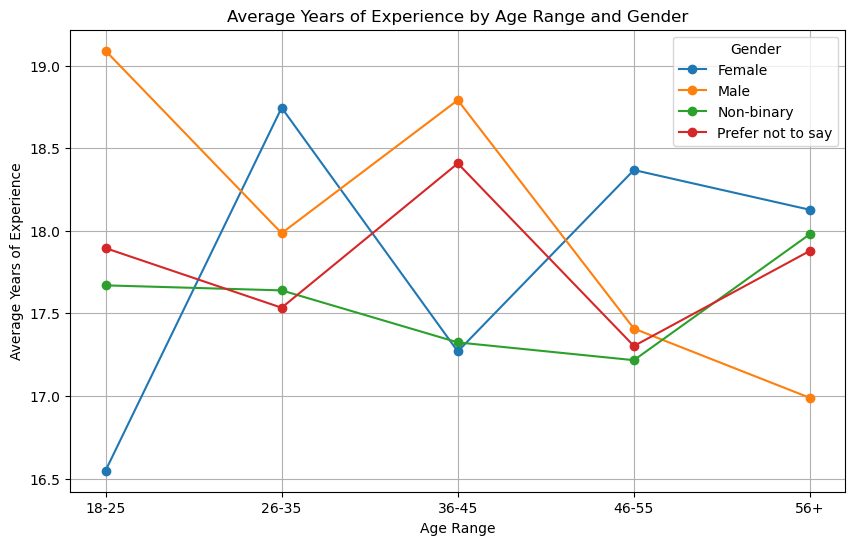

In [108]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Initialize dictionaries to hold data for plotting
age_ranges = ['18-25', '26-35', '36-45', '46-55', '56+']  # Assuming these are the ranges you defined
data_by_gender = defaultdict(lambda: [None] * len(age_ranges))  # Placeholder for each gender

# Collect the data from the aggregation results
for result in results:
    age_range = result["_id"]["Age_Range"]
    gender = result["_id"]["Gender"]
    average_experience = result["average_experience"]
    
    if age_range in age_ranges:  # Ensure the age range is valid
        index = age_ranges.index(age_range)
        data_by_gender[gender][index] = average_experience

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot line for each gender
for gender, averages in data_by_gender.items():
    plt.plot(age_ranges, averages, label=f'{gender}', marker='o')

# Customize the plot
plt.title('Average Years of Experience by Age Range and Gender')
plt.xlabel('Age Range')
plt.ylabel('Average Years of Experience')
plt.legend(title='Gender')
plt.grid(True)

# Display the plot
plt.show()


Summary Years of EXperience by age and gender General Trends:

As individuals age, total experience tends to increase, particularly for females in the younger age groups.
Males have consistently higher average experience at younger ages, but this trend appears to shift as they age, particularly in the 46-55 age group where females surpass them.
Experience Distribution:

The highest total experiences are found in the 26-35 age group, indicating a peak work experience level during these years.
In older age groups, experience levels drop, likely reflecting retirement trends and reduced workforce participation.
Gender Comparisons:

Females tend to have slightly lower total experiences in the youngest age group, but their averages rise significantly in the older age brackets.
Males generally have higher total experience in the early years but see a decline relative to females as age increases.
This summary highlights key patterns in work experience across different age groups and genders, offering insights into career progression and workforce dynamics.

In [109]:
pipeline = [
    {
        "$match": {
            "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
            "Years_of_Experience": {"$exists": True, "$ne": None},
            "Work_Life_Balance_Rating": {"$exists": True, "$ne": None}
           
        }
    },

    {
        "$group": {
            "_id": {"Work_Life_Balance_Rating":"$Work_Life_Balance_Rating",
                    "Years_of_Experience":"$Years_of_Experience"
                    },
            "total_hours": {"$sum": "$Hours_Worked_Per_Week"},
            "average_hours": {"$avg": "$Hours_Worked_Per_Week"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# print aggregated results
for result in results:
    work_life= result["_id"]["Work_Life_Balance_Rating"]
    years_of_experience = result["_id"]["Years_of_Experience"]
    total_hours = result["total_hours"]
    average_hours = result["average_hours"]
    count = result["count"]
    print(f"Work life in experience and hours worked per week: {work_life}, {years_of_experience}, Total_hours: {total_hours}, Average Hours：{average_hours:.2f}, Count: {count}")

Work life in experience and hours worked per week: 1, 1, Total_hours: 869, Average Hours：37.78, Count: 23
Work life in experience and hours worked per week: 1, 2, Total_hours: 909, Average Hours：41.32, Count: 22
Work life in experience and hours worked per week: 1, 3, Total_hours: 1397, Average Hours：34.92, Count: 40
Work life in experience and hours worked per week: 1, 4, Total_hours: 1266, Average Hours：40.84, Count: 31
Work life in experience and hours worked per week: 1, 5, Total_hours: 1012, Average Hours：42.17, Count: 24
Work life in experience and hours worked per week: 1, 6, Total_hours: 1337, Average Hours：40.52, Count: 33
Work life in experience and hours worked per week: 1, 7, Total_hours: 1516, Average Hours：39.89, Count: 38
Work life in experience and hours worked per week: 1, 8, Total_hours: 1094, Average Hours：40.52, Count: 27
Work life in experience and hours worked per week: 1, 9, Total_hours: 1116, Average Hours：39.86, Count: 28
Work life in experience and hours worke

In [110]:

import pandas as pd

# Run the aggregation pipeline and fetch results
results = collection.aggregate(pipeline)

# Create an empty list to hold the rows for the DataFrame
data = []

# Iterate through the results and append them to the list
for result in results:
    data.append({
        "Work_Life_Balance_Rating": result["_id"]["Work_Life_Balance_Rating"],
        "Years_of_Experience": result["_id"]["Years_of_Experience"],
        "average_hours": result["average_hours"],
        "count": result["count"]
    })

# Convert the list to a DataFrame
df = pd.DataFrame(data)

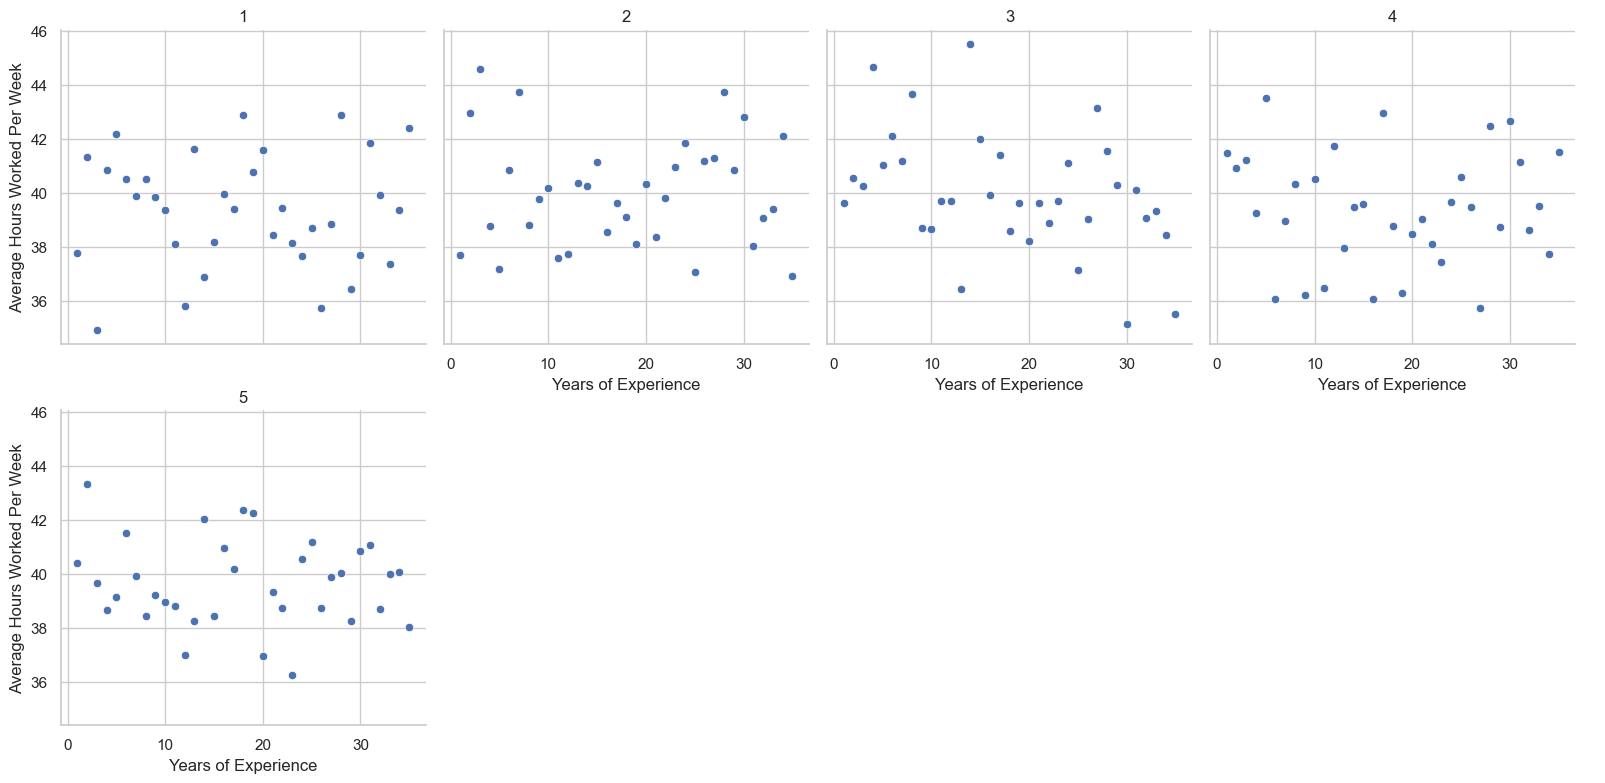

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame `df` created as in your code

# Set the visual style
sns.set(style="whitegrid")

# Create a FacetGrid with 'Work_Life_Balance_Rating' as the columns
g = sns.FacetGrid(df, col="Work_Life_Balance_Rating", col_wrap=4, height=4, aspect=1)

# Map the scatter plot to the grid
g.map(sns.scatterplot, "Years_of_Experience", "average_hours", marker="o")

# Add titles and labels
g.set_axis_labels("Years of Experience", "Average Hours Worked Per Week")
g.set_titles(col_template="{col_name}")
g.add_legend()

# Show the plot
plt.show()


Summary A chart to see if years of experience correlates with hours worked per week and work life balance

Variation in Hours: The average hours worked per week varies by experience level, suggesting that individuals with more experience may work longer hours on average in some weeks.
Consistent Count of Participants: The count of participants remains fairly stable across experience levels, indicating a diverse sample for analysis.
Trends: In general, the averages tend to hover around the mid-30s to low-40s hours per week, suggesting a typical full-time work scenario with variations based on the week and experience level.
The data illustrates a comprehensive view of work-life balance across different experience levels, indicating that hours worked can vary significantly but generally remain within a common range for most participants. Further analysis could focus on identifying specific trends or outliers within particular weeks or experience levels.